In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp  "/content/drive/My Drive/AML/Project/Data/preprocessed_full.csv" .
!cp  -r "/content/drive/My Drive/AML/Project/milestone/codes/transformers" .

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
data_full = pd.read_csv("preprocessed_full.csv")
#concert to string from object
data_full["Text"]= data_full["Text"].astype("str")

## Step 2.5: Train / Validate / Test Split
* 64% training set, 16% validation set, 20% test set

In [ ]:
from sklearn.model_selection import train_test_split
X = data_full[["Text"]].values
y = data_full[["IsHate"]].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape, X_validate.shape, X_test.shape)

(30496, 1) (7625, 1) (9531, 1)


## Word2Vector
##### At a high level, W2V embeddings of your vocabulary into a vector space is a kind of “side effect” of building certain neural net algorithms designed to do tasks like autocompletion or detecting likely adjacent words in a document. As the neural net “reads” through document after document, learning how to represent the vocabulary into a format that it can process in its “hidden layer(s)” in order to predict the most likely missing words, the algorithm learns something about the relations that each of the terms in the vocabulary have with respect to one another, based on the frequencies with which they come together. These patterns end up getting encoded into a matrix that after a while is able to map any word in the vocabulary to a vector in a much lower dimensional vector space.

### explore Word2Vector

In [ ]:
!pip install gensim
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict 
from time import time

### Check data frequency in dataset

In [ ]:
combine = np.concatenate((X_train, X_validate), axis = 0)
sent = [row[0].split() for row in combine]
#Creates the relevant phrases from the list of sentences
phrases = Phrases(sent, min_count=30, progress_per=10000)
#The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:
#Transform the corpus based on the bigrams detected:
bigram = Phraser(phrases)
sentences = bigram[sent]
#check most frequent words
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
print(len(word_freq))
print(sorted(word_freq, key=word_freq.get, reverse=True)[:10])

40564
['rt', 'bitch', 'get', 'I', 'mkr', 'hoe', 'like', 'go', 'fuck', 'pussy']


### Build word vocabulary and test word similarity in trained data

In [ ]:
import multiprocessing
from gensim.models import Word2Vec
cores = multiprocessing.cpu_count() 
print(cores)
#step one, Word2Vec(), set up the parameters of the model one by one
w2v_model = Word2Vec(min_count=20,
                     window=2, #maximum distance between the current and predicted word within a sentence
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)
#step two, .build_vocab(), builds the vocabulary from a sequence of sentences and thus initialized the model., parameter of min_count and sample
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
#step three, .train()
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

2
Time to build vocab: 0.03 mins
Time to train the model: 0.83 mins


In [ ]:
print(w2v_model.wv.most_similar(positive=["fuck"]))
print(w2v_model.wv.most_similar(positive=["hoe"]))

[('skinny', 0.9360010623931885), ('son', 0.9359089136123657), ('girlfriend', 0.9335215091705322), ('wack', 0.9298356175422668), ('fuckin', 0.9285135269165039), ('spit', 0.9268032312393188), ('ass', 0.9257853031158447), ('yo', 0.9248380661010742), ('daddy', 0.9229880571365356), ('ya', 0.9208645224571228)]
[('niggas', 0.9608736634254456), ('bitch', 0.9451465606689453), ('gon', 0.9450971484184265), ('tryna', 0.9444702863693237), ('dese', 0.9433870315551758), ('jus', 0.9429365992546082), ('nigga', 0.9363449811935425), ('naw', 0.9325780868530273), ('lil', 0.930949866771698), ('actin', 0.9308527708053589)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### Visualize the semantic similarity in most-frequently appeared words

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


<Figure size 3600x2400 with 0 Axes>

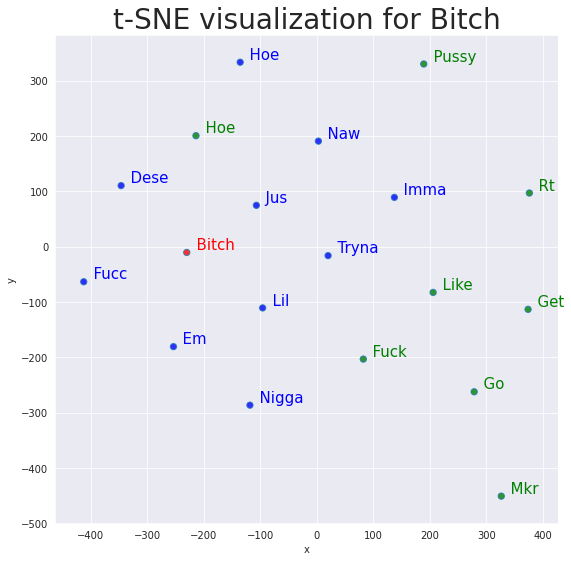

In [ ]:
#t-SNE visualizations: non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#plot 300 dimension in 2 dimension
def tsnescatterplot(model, word, list_names):
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']
    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)   
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=18).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    plt.figure(dpi = 600)
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)            
    plt.title('t-SNE visualization for {}'.format(word.title()), fontsize = 28)
#query word (in **red**), its most similar words in the model (in **blue**), and other words from the vocabulary (in **green**)
tsnescatterplot(w2v_model, 'bitch', ['rt' , 'get', 'mkr', 'hoe', 'like', 'go', 'fuck', 'pussy']) 

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training set accuracy 0.5622376705141658


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


elapsed:  7.657477140426636


Pipeline(memory=None,
         steps=[('w2v',
                 GensimWord2VecVectorizer(alpha=0.025, batch_words=10000,
                                          callbacks=(), cbow_mean=1,
                                          compute_loss=False,
                                          hashfxn=<built-in function hash>,
                                          hs=0, iter=10, max_final_vocab=None,
                                          max_vocab_size=None, min_alpha=0.0001,
                                          min_count=3, negative=5,
                                          ns_exponent=0.75, null_word=0,
                                          sample=0.001, seed=1, sg=1, size=100,
                                          sorted_vocab=1, trim_rule=Non...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.01,
 

Training set accuracy 0.5622048793284365


array([[  103, 13351],
       [    0, 17042]])